# Strategy 3
A follow through from Strategy 2. But with more specific parameter tuning

In [1]:
# DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))  # adds project root

## Imports

In [3]:
import pandas as pd
import yfinance as yf
from src.functions.plot_position import plot_positions_ma
from src.functions.plot_position import plot_positions_vb
import numpy as np
from src.functions.position_VB import positionVB
import plotly.express as px
from src.functions.plot_position import plot_positions_2mas
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Data Loading

In [4]:
file_path = "/Users/shah/CODE_BOOK_3/code_document/hfdProject/HFD-Final-Project/data/data1_2023_Q3.parquet"

dataQ3 = pd.read_parquet(file_path)
dataQ3

,datetime,NQ,SP
0,2023-07-03 09:31:00+00:00,15187.069,4442.692
1,2023-07-03 09:32:00+00:00,15204.149,4443.182
2,2023-07-03 09:33:00+00:00,15205.739,4444.906
3,2023-07-03 09:34:00+00:00,15203.729,4446.687
4,2023-07-03 09:35:00+00:00,15200.169,4446.889
...,...,...,...
25143,2023-09-29 15:56:00+00:00,14703.129,4285.614
25144,2023-09-29 15:57:00+00:00,14705.529,4285.382
25145,2023-09-29 15:58:00+00:00,14723.299,4290.132
25146,2023-09-29 15:59:00+00:00,14715.569,4288.376


## Analysing Falls

In [10]:
import numpy as np
import pandas as pd

p = pd.to_numeric(dataQ3["NQ"], errors="coerce").to_numpy()
n = len(p)

fwd15 = pd.Series(p).rolling(15).mean().shift(-14).to_numpy()

falls = []
i = 1

while i < n - 15:
    if not (np.isfinite(p[i]) and np.isfinite(p[i-1]) and np.isfinite(fwd15[i])):
        i += 1
        continue

    # start fall on negative return
    if p[i] < p[i-1]:
        start = i - 1
        peak = p[start]
        i += 1

        # wait for positive returns; decide stop/continue using fwd15 at that time
        while i < n - 15:
            if not (np.isfinite(p[i]) and np.isfinite(p[i-1]) and np.isfinite(fwd15[i])):
                i += 1
                continue

            if p[i] > p[i-1]:  # bounce point
                if p[i] <= fwd15[i]:  # stop fall here
                    trough = p[i]
                    falls.append((i - start, trough - peak))
                    i += 1
                    break
                # else: fall continues; keep waiting for next positive return

            i += 1
    else:
        i += 1

falls_df = pd.DataFrame(falls, columns=["duration_min", "max_fall"])


In [ ]:
### DUPLICATE LOGIC ### THIS CELL IS REPLACED BY PARAMETER TUNING INSIDE THE NEXT CELL ###

import numpy as np

dataQ1['NQ_SMA60'] = dataQ1['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ1['NQ_SMA60'] = dataQ1['NQ_SMA60'].where(~dataQ1['NQ'].isna(), np.nan)
dataQ1['NQ_STD60'] = dataQ1['NQ'].rolling(window = 60, min_periods = 30).std()

NQ = dataQ1["NQ"].to_numpy()
SMA60 = dataQ1["NQ_SMA60"].to_numpy()
STD60 = dataQ1["NQ_STD60"].to_numpy()

freq = falls_df["duration_min"].value_counts().sort_index()
cdf = freq.cumsum() / freq.sum()

D1 = int(cdf[cdf >= 0.50].index[0])
D2 = int(cdf[cdf >= 0.95].index[0])

z = (NQ - SMA60) / np.where(STD60 ==0, np.nan, STD60)

# since falls_df has no z_min, use global |z| quantiles as band multipliers
z_abs = np.abs(z[np.isfinite(z)])

k1 = float(np.nanquantile(z_abs, 0.80))
k2 = float(np.nanquantile(z_abs, 0.90))
k3 = float(np.nanquantile(z_abs, 0.97))

k1, k2, k3 = sorted([k1, k2, k3])
k1, k2, k3, D1 , D2

(1.721961975587152, 2.1893750468591424, 3.0804060597791043, 3, 28)

In [7]:
### NEEDED ONCE ###
dataQ1 = dataQ1.set_index("datetime")
dataQ1.index

DatetimeIndex(['2023-01-02 09:31:00+00:00', '2023-01-02 09:32:00+00:00',
               '2023-01-02 09:33:00+00:00', '2023-01-02 09:34:00+00:00',
               '2023-01-02 09:35:00+00:00', '2023-01-02 09:36:00+00:00',
               '2023-01-02 09:37:00+00:00', '2023-01-02 09:38:00+00:00',
               '2023-01-02 09:39:00+00:00', '2023-01-02 09:40:00+00:00',
               ...
               '2023-03-31 15:51:00+00:00', '2023-03-31 15:52:00+00:00',
               '2023-03-31 15:53:00+00:00', '2023-03-31 15:54:00+00:00',
               '2023-03-31 15:55:00+00:00', '2023-03-31 15:56:00+00:00',
               '2023-03-31 15:57:00+00:00', '2023-03-31 15:58:00+00:00',
               '2023-03-31 15:59:00+00:00', '2023-03-31 16:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='datetime', length=25109, freq=None)

## Original Strategy 02 (02)

In [ ]:
### FLIPPED BY DESIGN
import numpy as np
import pandas as pd

# Build symmetric volatility bands around SMA60 using STD60-scaled multipliers k1/k2/k3
dataQ1["upper_1"] = dataQ1["NQ_SMA60"] + k1 * dataQ1["NQ_STD60"]
dataQ1["upper_2"] = dataQ1["NQ_SMA60"] + k2 * dataQ1["NQ_STD60"]
dataQ1["upper_3"] = dataQ1["NQ_SMA60"] + k3 * dataQ1["NQ_STD60"]

dataQ1["lower_1"] = dataQ1["NQ_SMA60"] - k1 * dataQ1["NQ_STD60"]
dataQ1["lower_2"] = dataQ1["NQ_SMA60"] - k2 * dataQ1["NQ_STD60"]
dataQ1["lower_3"] = dataQ1["NQ_SMA60"] - k3 * dataQ1["NQ_STD60"]

# Pull numpy arrays for speed inside the loop
NQ  = dataQ1["NQ"].to_numpy()          # price
SMA = dataQ1["NQ_SMA60"].to_numpy()    # mean reference (SMA60)

U1 = dataQ1["upper_1"].to_numpy()      # inner upper band (k1)
U2 = dataQ1["upper_2"].to_numpy()      # outer upper band (k2)
L1 = dataQ1["lower_1"].to_numpy()      # inner lower band (k1)
L2 = dataQ1["lower_2"].to_numpy()      # outer lower band (k2)

n = len(dataQ1)

# Outputs: position (+1/-1/0) and regime flag (0=MR, 1=MOM)
pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

# State variables
mode    = 0        # 0 = mean-reversion mode, 1 = momentum mode
persist = 0        # counts consecutive bars spent below L1
D1      = 5        # persistence threshold required to confirm downside persistence

for t in range(1, n):

    # If any required value is missing at t-1, force flat and carry regime state
    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    # Update persistence counter: increment while price stays below L1, else reset to 0
    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    # Regime switch: MR -> MOM when price is deeply below L2 AND downside has persisted for D1 bars
    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        continue

    # # Regime switch: MOM -> MR when price re-enters the inner band region [L1, U1]
    # if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
    #     mode = 0
    #     pos[t] = 0
    #     persist = 0
    #     regime[t] = mode
    #     continue
    if mode == 1 and ((pos[t-1] == 1 and NQ[t-1] <= SMA[t-1]) or (pos[t-1] == -1 and NQ[t-1] >= SMA[t-1])):
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    # Mean-reversion logic (only when mode == 0)
    if mode == 0:

        # If currently flat, open MR position on band breach (contrarian to breach direction)
        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = -1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = 1
            else:
                pos[t] = 0

        # If in an MR trade, hold until price crosses back through the SMA (mean)
        else:
            if (pos[t-1] == -1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == 1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    # Momentum logic (only when mode == 1): maintain the current position until regime exit
    else:
        pos[t] = pos[t-1]

    # Record regime state at time t
    regime[t] = mode

# Save results back to the dataframe
dataQ1["position_3"] = pos
dataQ1["regime_3"]   = regime


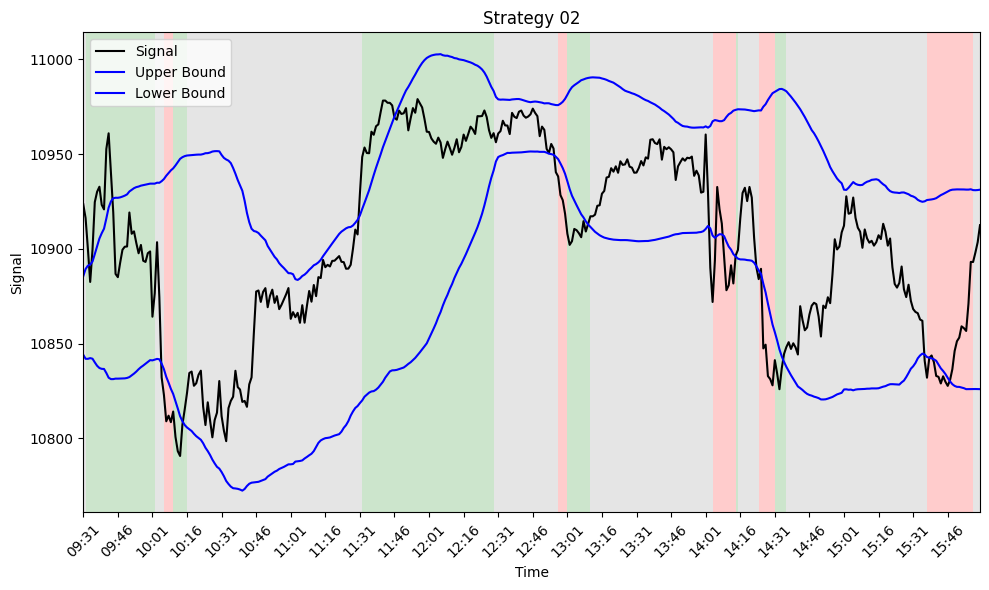

NQ            float64
SP            float64
NQ_SMA60      float64
NQ_STD60      float64
upper_1       float64
upper_2       float64
upper_3       float64
lower_1       float64
lower_2       float64
lower_3       float64
position_3       int8
regime_3         int8
dtype: object

In [14]:

plot_positions_vb(
    data_plot=dataQ1,
    date_plot="2023-01-04",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 02"
)
dataQ1.dtypes

## Param tuning

In [7]:
import numpy as np
### NEEDED ONCE ###
dataQ3 = dataQ3.set_index("datetime")
dataQ3.index


DatetimeIndex(['2023-07-03 09:31:00+00:00', '2023-07-03 09:32:00+00:00',
               '2023-07-03 09:33:00+00:00', '2023-07-03 09:34:00+00:00',
               '2023-07-03 09:35:00+00:00', '2023-07-03 09:36:00+00:00',
               '2023-07-03 09:37:00+00:00', '2023-07-03 09:38:00+00:00',
               '2023-07-03 09:39:00+00:00', '2023-07-03 09:40:00+00:00',
               ...
               '2023-09-29 15:51:00+00:00', '2023-09-29 15:52:00+00:00',
               '2023-09-29 15:53:00+00:00', '2023-09-29 15:54:00+00:00',
               '2023-09-29 15:55:00+00:00', '2023-09-29 15:56:00+00:00',
               '2023-09-29 15:57:00+00:00', '2023-09-29 15:58:00+00:00',
               '2023-09-29 15:59:00+00:00', '2023-09-29 16:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='datetime', length=25148, freq=None)

In [8]:

dataQ3['NQ_SMA60'] = dataQ3['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ3['NQ_SMA60'] = dataQ3['NQ_SMA60'].where(~dataQ3['NQ'].isna(), np.nan)
dataQ3['NQ_STD60'] = dataQ3['NQ'].rolling(window = 60, min_periods = 30).std()


In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm

FLIP = False  # set False to keep original

# ---------- Preconditions ----------
NQ    = dataQ3["NQ"].to_numpy()
SMA   = dataQ3["NQ_SMA60"].to_numpy()
STD60 = dataQ3["NQ_STD60"].to_numpy()
n = len(dataQ3)

z = (NQ - SMA) / np.where(STD60 == 0, np.nan, STD60)
z_abs = np.abs(z[np.isfinite(z)])

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

# ---------- Grids (10 steps each) ----------
D1_grid = np.linspace(0.50, 0.99, 10)
k1_grid = np.linspace(0.70, 0.95, 10)
k2_grid = np.linspace(0.75, 0.98, 10)
k3_grid = np.linspace(0.80, 0.995, 10)

best_sharpe = -np.inf
best_params = None

# ---------- Grid Search ----------
# for D1_p in D1_grid:
for D1_p in tqdm(D1_grid, desc="D1_grid"):


    D1 = int(cdf[cdf >= D1_p].index[0])  # persistence threshold

    # for k1_p in k1_grid:
    for k1_p in tqdm(k1_grid, desc="k1_grid", leave=False):
        # for k2_p in k2_grid:
        for k2_p in tqdm(k2_grid, desc="k2_grid", leave=False):
            # for k3_p in k3_grid:
            for k3_p in tqdm(k3_grid, desc="k3_grid", leave=False):
                if not (k1_p < k2_p < k3_p):
                    continue

                k1 = float(np.nanquantile(z_abs, k1_p))
                k2 = float(np.nanquantile(z_abs, k2_p))
                k3 = float(np.nanquantile(z_abs, k3_p))
                k1, k2, k3 = sorted([k1, k2, k3])

                dataQ3["upper_1"] = dataQ3["NQ_SMA60"] + k1 * dataQ3["NQ_STD60"]
                dataQ3["upper_2"] = dataQ3["NQ_SMA60"] + k2 * dataQ3["NQ_STD60"]
                dataQ3["upper_3"] = dataQ3["NQ_SMA60"] + k3 * dataQ3["NQ_STD60"]

                dataQ3["lower_1"] = dataQ3["NQ_SMA60"] - k1 * dataQ3["NQ_STD60"]
                dataQ3["lower_2"] = dataQ3["NQ_SMA60"] - k2 * dataQ3["NQ_STD60"]
                dataQ3["lower_3"] = dataQ3["NQ_SMA60"] - k3 * dataQ3["NQ_STD60"]

                U1 = dataQ3["upper_1"].to_numpy()
                U2 = dataQ3["upper_2"].to_numpy()
                L1 = dataQ3["lower_1"].to_numpy()
                L2 = dataQ3["lower_2"].to_numpy()

                pos    = np.zeros(n, dtype=np.int8)
                regime = np.zeros(n, dtype=np.int8)

                mode    = 0
                persist = 0

                # ---------- Main loop ----------
                for t in range(1, n):
                # for t in tqdm(range(1, n), desc="main loop", leave=False):
                    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
                        pos[t] = 0
                        regime[t] = mode
                        continue

                    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

                    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
                        mode = 1
                        pos[t] = 1
                        regime[t] = mode
                        continue

                    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
                        mode = 0
                        pos[t] = 0
                        persist = 0
                        regime[t] = mode
                        continue

                    if mode == 0:

                        if pos[t-1] == 0:
                            if NQ[t-1] < L1[t-1]:
                                pos[t] = -1
                            elif NQ[t-1] > U1[t-1]:
                                pos[t] = 1
                            else:
                                pos[t] = 0

                        else:
                            if (pos[t-1] == -1 and NQ[t-1] >= SMA[t-1]) or \
                               (pos[t-1] == 1 and NQ[t-1] <= SMA[t-1]):
                                pos[t] = 0
                            else:
                                pos[t] = pos[t-1]

                    else:
                        pos[t] = pos[t-1]

                    regime[t] = mode

                # r = pos[:-1] * np.diff(NQ) # without transaction cost
                r = pos[:-1] * np.diff(NQ) - 0.12 * np.abs(np.diff(pos)) # with transaction cost
                sharpe = np.nanmean(r) / np.nanstd(r) if np.nanstd(r) > 0 else -np.inf

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = (D1_p, k1_p, k2_p, k3_p, D1, k1, k2, k3)

# ---------- Re-run strategy once with best Sharpe params and save ----------
D1_p, k1_p, k2_p, k3_p, D1, k1, k2, k3 = best_params

D1 = int(cdf[cdf >= D1_p].index[0])
k1 = float(np.nanquantile(z_abs, k1_p))
k2 = float(np.nanquantile(z_abs, k2_p))
k3 = float(np.nanquantile(z_abs, k3_p))

dataQ3["upper_1"] = dataQ3["NQ_SMA60"] + k1 * dataQ3["NQ_STD60"]
dataQ3["upper_2"] = dataQ3["NQ_SMA60"] + k2 * dataQ3["NQ_STD60"]
dataQ3["upper_3"] = dataQ3["NQ_SMA60"] + k3 * dataQ3["NQ_STD60"]

dataQ3["lower_1"] = dataQ3["NQ_SMA60"] - k1 * dataQ3["NQ_STD60"]
dataQ3["lower_2"] = dataQ3["NQ_SMA60"] - k2 * dataQ3["NQ_STD60"]
dataQ3["lower_3"] = dataQ3["NQ_SMA60"] - k3 * dataQ3["NQ_STD60"]

U1 = dataQ3["upper_1"].to_numpy()
U2 = dataQ3["upper_2"].to_numpy()
L1 = dataQ3["lower_1"].to_numpy()
L2 = dataQ3["lower_2"].to_numpy()

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode    = 0
persist = 0

# for t in range(1, n):
for t in tqdm(range(1, n), desc="main loop", leave=False):

    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        continue

    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    if mode == 0:

        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = -1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = 1
            else:
                pos[t] = 0

        else:
            if (pos[t-1] == -1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == 1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        pos[t] = pos[t-1]

    regime[t] = mode

dataQ3["position_3"] = (-pos if FLIP else pos)
dataQ3["regime_3"]   = regime


D1_grid:   0%|          | 0/10 [00:00<?, ?it/s]

























































































































































































































































































































































































































































































































































































































































































D1_grid:  10%|█         | 1/10 [00:20<03:08, 20.93s/it]









































































































































































































































In [20]:
D1_p, k1_p, k2_p, k3_p, D1, k1, k2, k3

(np.float64(0.5),
 np.float64(0.7833333333333333),
 np.float64(0.9288888888888889),
 np.float64(0.9299999999999999),
 3,
 1.6983732021885336,
 2.382773440223733,
 2.392541798999659)

## Best Params

In [57]:
# best_dict = {"D1_p": D1_p, "k1_p": k1_p, "k2_p": k2_p, "k3_p": k3_p, "D1": D1, "k1": k1, "k2": k2, "k3": k3}
# np.save("../params/best_params_20stp.npy", best_dict)

In [ ]:
# best_dict = np.load("../params/best_params_20stp.npy", allow_pickle=True).item()


In [4]:
best_dict

{'D1_p': np.float64(0.5),
 'k1_p': np.float64(0.7263157894736841),
 'k2_p': np.float64(0.8468421052631578),
 'k3_p': np.float64(0.8513157894736842),
 'D1': 3,
 'k1': 1.4997528356374712,
 'k2': 1.9037554712461142,
 'k3': 1.927952358125672}

In [ ]:
# D1_p, k1_p, k2_p, k3_p, D1, k1, k2, k3 = (best_dict["D1_p"], best_dict["k1_p"], best_dict["k2_p"], best_dict["k3_p"], best_dict["D1"], best_dict["k1"], best_dict["k2"], best_dict["k3"])


## OOS 

In [14]:
file_path = "/Users/shah/CODE_BOOK_3/code_document/hfdProject/HFD-Final-Project/data/data1_2023_Q4.parquet"

dataQ4 = pd.read_parquet(file_path)
dataQ4

,datetime,NQ,SP
0,2023-10-02 09:31:00+00:00,14705.039,4279.864
1,2023-10-02 09:32:00+00:00,14731.789,4283.120
2,2023-10-02 09:33:00+00:00,14735.499,4283.870
3,2023-10-02 09:34:00+00:00,14753.119,4285.364
4,2023-10-02 09:35:00+00:00,14758.309,4286.370
...,...,...,...
24947,2023-12-29 15:56:00+00:00,16817.639,4767.177
24948,2023-12-29 15:57:00+00:00,16823.369,4769.370
24949,2023-12-29 15:58:00+00:00,16817.169,4768.117
24950,2023-12-29 15:59:00+00:00,16819.479,4769.614


In [15]:
import numpy as np
### NEEDED ONCE ###
dataQ4 = dataQ4.set_index("datetime")
dataQ4.index

DatetimeIndex(['2023-10-02 09:31:00+00:00', '2023-10-02 09:32:00+00:00',
               '2023-10-02 09:33:00+00:00', '2023-10-02 09:34:00+00:00',
               '2023-10-02 09:35:00+00:00', '2023-10-02 09:36:00+00:00',
               '2023-10-02 09:37:00+00:00', '2023-10-02 09:38:00+00:00',
               '2023-10-02 09:39:00+00:00', '2023-10-02 09:40:00+00:00',
               ...
               '2023-12-29 15:51:00+00:00', '2023-12-29 15:52:00+00:00',
               '2023-12-29 15:53:00+00:00', '2023-12-29 15:54:00+00:00',
               '2023-12-29 15:55:00+00:00', '2023-12-29 15:56:00+00:00',
               '2023-12-29 15:57:00+00:00', '2023-12-29 15:58:00+00:00',
               '2023-12-29 15:59:00+00:00', '2023-12-29 16:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='datetime', length=24952, freq=None)

In [16]:

dataQ4['NQ_SMA60'] = dataQ4['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ4['NQ_SMA60'] = dataQ4['NQ_SMA60'].where(~dataQ4['NQ'].isna(), np.nan)
dataQ4['NQ_STD60'] = dataQ4['NQ'].rolling(window = 60, min_periods = 30).std()


In [ ]:
# ---------- Re-run strategy once with best Sharpe params and save ----------
# D1 = int(cdf[cdf >= D1_p].index[0])
# k1 = float(np.nanquantile(z_abs, k1_p))
# k2 = float(np.nanquantile(z_abs, k2_p))
# k3 = float(np.nanquantile(z_abs, k3_p))


dataQ4["upper_1"] = dataQ4["NQ_SMA60"] + k1 * dataQ4["NQ_STD60"]
dataQ4["upper_2"] = dataQ4["NQ_SMA60"] + k2 * dataQ4["NQ_STD60"]
dataQ4["upper_3"] = dataQ4["NQ_SMA60"] + k3 * dataQ4["NQ_STD60"]

dataQ4["lower_1"] = dataQ4["NQ_SMA60"] - k1 * dataQ4["NQ_STD60"]
dataQ4["lower_2"] = dataQ4["NQ_SMA60"] - k2 * dataQ4["NQ_STD60"]
dataQ4["lower_3"] = dataQ4["NQ_SMA60"] - k3 * dataQ4["NQ_STD60"]

U1 = dataQ4["upper_1"].to_numpy()
U2 = dataQ4["upper_2"].to_numpy()
L1 = dataQ4["lower_1"].to_numpy()
L2 = dataQ4["lower_2"].to_numpy()
n = len(dataQ4)

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode    = 0
persist = 0

# Pull numpy arrays for speed inside the loop
NQ  = dataQ4["NQ"].to_numpy()          # price
SMA = dataQ4["NQ_SMA60"].to_numpy()    # mean reference (SMA60)


for t in range(1, n):
    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        continue

    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    if mode == 0:

        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = -1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = 1
            else:
                pos[t] = 0

        else:
            if (pos[t-1] == -1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == 1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        pos[t] = pos[t-1]

    regime[t] = mode

dataQ4["position_3"] = pos
dataQ4["regime_3"]   = regime


In [21]:

net_profit = np.nansum(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy()))
sharpe = np.nanmean(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy())) / np.nanstd(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy()))

print(net_profit)
print(sharpe)

-305.3559999999907
-0.002099365961616451


## Plot

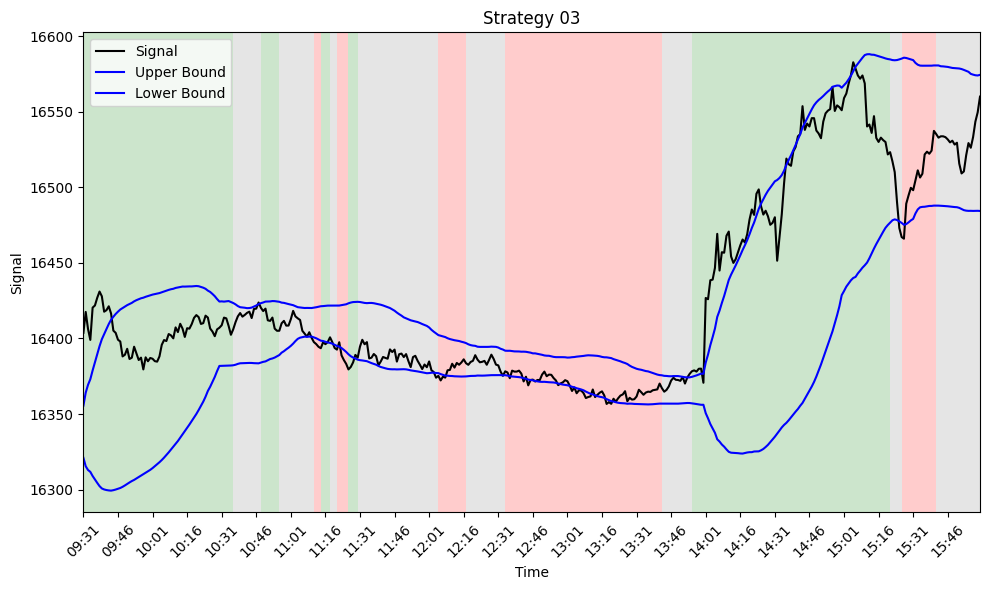

<Axes: title={'center': 'Strategy 03'}, xlabel='Time', ylabel='Signal'>

In [27]:

plot_positions_vb(
    data_plot=dataQ4,
    date_plot="2023-12-13",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 03"
)